# Contextual Bandits Agent with Policy Gradient Method in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.  

In [169]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd


In [170]:
import traceback
from scipy.special import expit

In [171]:
class PredictionMarket:
    n_outcomes = 0
    outcomes_list = []
    
    def __init__(self, outcomes_list):
        self.outcomes_list = outcomes_list.copy()
        self.n_outcomes = len(outcomes_list)
        self.init_prediction = np.ones(self.n_outcomes)/ self.n_outcomes
        self.current_prediction = self.init_prediction
        
    def report(self, prediction):
        assert len(prediction) == self.n_outcomes, 'Number of outcomes not fit!'
        assert sum(prediction) == 1, print('Probabilities not sum to one!', prediction)
        # Record the contract if multiple traders.
        self.current_prediction = prediction.copy()
        
    def log_resolve(self, materialised_index):
        assert materialised_index < self.n_outcomes, 'Index out of scope!'
        scores = np.log(self.current_prediction) - np.log(self.init_prediction)
        return scores[materialised_index]

In [172]:
class Bucket:
    
    def __init__(self, prior_red = 0.5):
        assert prior_red >= 0, 'Prior can not be negative!'
        assert prior_red <=1, 'Prior can not greater than one!'
        
        self.prior_red = prior_red
        self.colour = np.random.choice(['red_bucket', 'blue_bucket'], p=(self.prior_red, 1 - self.prior_red))
        if self.colour == 'red_bucket':
            self.ball_list = ['red', 'red', 'blue']
        else:
            self.ball_list = ['blue', 'blue', 'red']
    
    def signal(self):
        return np.random.choice(self.ball_list)

In [173]:
class Agent:
    
    def __init__(self, feature_shape, learn_rate, batch_size = 128,beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
        self.w_mean = np.zeros(feature_shape)
        self.w_std = np.zeros(feature_shape)
        self.learn_rate = learn_rate
        self.reward_history = np.empty((1, 3))
        self.baseline = 0
        
        # Momentum variables
        self.beta1 = beta1
        self.v_dw_mean = np.zeros(feature_shape)
        self.v_dw_std = np.zeros(feature_shape)
        
        # RMSprop variables
        self.beta2 = beta2
        self.epsilon = epsilon
        self.s_dw_mean = np.zeros(feature_shape)
        self.s_dw_std = np.zeros(feature_shape)

        # Experience replay
        self.experience = []
        self.batch_size = batch_size
        self.experience_size = 0
        
    def sigmoid(self, preference):
        return 1/ (1 + np.exp(-preference))
    
    def gaussian(self, x, mu, sigma):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))
    
    def gradient_approx(self, features, epsilon = 1e-7):
        
        J_plus = np.zeros(self.w_mean.shape)
        J_minus = np.zeros(self.w_mean.shape)
        
        for i in range(J_plus.shape[1]):
            self.w_mean[:, i] += epsilon
            reports = self.report(features)
            J_plus[:, i] = (np.log(reports[0]) - np.log(0.5) )
            self.w_mean[:, i] -= epsilon
            
        for i in range(J_minus.shape[1]):
            self.w_mean[:, i] -= epsilon
            reports = self.report(features)
            J_minus[:, i] = (np.log(reports[0]) - np.log(0.5) )
            self.w_mean[:, i] += epsilon
    
        gradapprox = (J_plus - J_minus)/ (2*epsilon)

        return gradapprox
    
    def report(self, features_list):
        
        self.features = features_list

        features = np.array([features_list])

        self.means = np.inner(self.w_mean, features)
        self.stds = np.exp(np.inner(self.w_std, features))
        
        
        self.report_mean = np.mean(self.means)
        self.report_std = np.mean(self.stds)
        
            
        self.h = np.random.normal(self.report_mean, self.report_std)
        
        self.pi = self.sigmoid(self.h)
        
        if np.isnan(self.pi):
            print('h: ', self.h)
            print('report_mean:', self.report_mean)
            print('report_std:', self.report_std)
            print('means:', self.means)
            print('stds:', self.stds)
            print('features', features)
            raise AssertionError('Warning: report is None !!!')
        
        return [self.pi, 1 - self.pi]
    
    def __generate_log_policy_grad(self):
        gradient_mean = np.array([self.features]) *\
        ((self.h - self.report_mean)/ self.report_std**2) \
        * self.gaussian(self.h, self.report_mean, self.report_std) \
        * (1 - self.pi)
        
        gradient_std = np.array([self.features]) *\
        ((self.h - self.report_mean)**2 / self.report_std**2 - 1) \
        * self.gaussian(self.h, self.report_mean, self.report_std) \
        * (1 - self.pi)
        
#         if self.features[0, 1] == 1: # blue ball
#             gradient_mean *= 0.7
#             gradient_std *= 0.7
        
        return [gradient_mean, gradient_std]
    
    def __print_algorithm(self, t, algorithm):
        if t == 0:
            print('Updating weights with ' + algorithm + ' algorithm.')

    def store_experience(self, reward):
        entry = np.c_[self.features, self.h, self.pi, reward]
        self.experience = np.r_[self.experience, entry]
        self.experience_size += 1

    def __sample_experience(self):
        if self.experience_size < self.batch_size:
            return self.experience
        else:
            idx = np.random.randint(self.experience_size, size=self.batch_size)
            return self.experience[idx, :]


    def update(self, rewards, t, algorithm = 'adam'):

        
#         Baseline term
        # Nonstationary tracking
        self.baseline = self.beta1 * self.baseline + (1 - self.beta1) * rewards
        # Stationary tracking
#         self.baseline = self.baseline + (1/ (t+1)) * (rewards - self.baseline)
        rewards_diff = rewards - self.baseline
            
        self.reward_history = np.r_[self.reward_history, np.array([[rewards, self.baseline, rewards_diff]])]
        
        gradient_mean, gradient_std = self.__generate_log_policy_grad()
            
        if algorithm == 'baseline':
            rewards_corrected = rewards_diff/ (1 - np.power(self.beta1, t + 1))
        else:
            rewards_corrected = rewards
            
        gradient_mean *= rewards_corrected
        gradient_std *= rewards_corrected
        
        # momentum update
        self.v_dw_mean = self.beta1 * self.v_dw_mean + (1 - self.beta1) * gradient_mean
        self.v_dw_std = self.beta1 * self.v_dw_std + (1 - self.beta1) * gradient_std
        
        # RMSprop update
        self.s_dw_mean = self.beta2 * self.s_dw_mean + (1 - self.beta2) * (np.power(gradient_mean, 2))
        self.s_dw_std = self.beta2 * self.s_dw_std + (1 - self.beta2) * (np.power(gradient_std, 2))
        
        # bias correction
        v_dw_mean_corrected = self.v_dw_mean/ (1 - np.power(self.beta1, t + 1))
        v_dw_std_corrected = self.v_dw_std/ (1 - np.power(self.beta1, t + 1))
        s_dw_mean_corrected = self.s_dw_mean/ (1 - np.power(self.beta2, t + 1))
        s_dw_std_corrected = self.s_dw_std/ (1 - np.power(self.beta2, t + 1))
        
        # Adam term
        adam_dw_mean_corrected = (v_dw_mean_corrected/ (np.sqrt(s_dw_mean_corrected) + self.epsilon) )
        adam_dw_std_corrected = (v_dw_std_corrected/ (np.sqrt(s_dw_std_corrected) + self.epsilon))        
        
        # Only update the corresponding weights
#         kernel = self.features
#         kernel[:, -1] = 1 
#         v_dw_mean_corrected = np.multiply(v_dw_mean_corrected, kernel)
#         v_dw_std_corrected = np.multiply(v_dw_std_corrected, kernel)
#         s_dw_mean_corrected = np.multiply(s_dw_mean_corrected, kernel)
#         s_dw_std_corrected = np.multiply(s_dw_std_corrected, kernel)     

        
        # update weights
        
        # Adam algorithm
        if algorithm == 'adam':
            self.w_mean += self.learn_rate * adam_dw_mean_corrected
            self.w_std += self.learn_rate * adam_dw_std_corrected
            self.__print_algorithm(t, algorithm)
            
        # Momentum algorithm
        elif algorithm == 'momentum':
            self.w_mean += self.learn_rate * v_dw_mean_corrected
            self.w_std += self.learn_rate * v_dw_std_corrected            
            self.__print_algorithm(t, algorithm)
        # Regular Update
        else:
            self.w_mean += self.learn_rate * gradient_mean
            self.w_std += self.learn_rate * gradient_std
            self.__print_algorithm(t, algorithm)
        
        return np.array([gradient_mean, gradient_std, v_dw_mean_corrected, v_dw_std_corrected, adam_dw_mean_corrected, adam_dw_std_corrected])


In [174]:
def one_hot_encode(feature):
    if feature == 'red':
        return [1, 0]
    else:
        return [0, 1]
    
bucket_colour_to_num = {'red_bucket': 0, 'blue_bucket': 1}

In [175]:
def gradient_check(agent):

    pm = PredictionMarket(outcomes_list=['red_bucket', 'blue_bucket'])
    x = np.array([[1, 0, 0.5]])
    report = agent.report(x)
    gradapprox = agent.gradient_approx(x)
    pm.report(report)
    R = pm.log_resolve(0)
    gradient_mean, gradient_std = agent.update(R)
    
    numerator = np.linalg.norm(gradient_mean - gradapprox)                                           # Step 1'
    denominator = np.linalg.norm(gradient_mean) + np.linalg.norm(gradapprox)                                         # Step 2'
    difference = numerator/denominator
    
    if difference > 2e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference    

In [176]:
learning_rate = 0.001
training_episodes = 30000
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, baseline, regular
algorithm = 'adam'

agent = Agent(feature_shape=[1, 3], learn_rate=learning_rate, beta1=beta1, beta2=beta2)


mean_weights_history = np.empty((1, 3))
std_weights_history = np.empty((1, 3))

r_ball_mean_history = []
b_ball_mean_history = []
r_ball_std_history = []
b_ball_std_history = []

r_ball_pred_history = []
b_ball_pred_history = []

grad_r_ball_mean_history = np.empty((1, 3))
grad_b_ball_mean_history = np.empty((1, 3))
grad_r_ball_std_history = np.empty((1, 3))
grad_b_ball_std_history = np.empty((1, 3))

grad_r_ball_v_mean_history = np.empty((1, 3))
grad_b_ball_v_mean_history = np.empty((1, 3))
grad_r_ball_v_std_history = np.empty((1, 3))
grad_b_ball_v_std_history = np.empty((1, 3))

grad_r_ball_adam_mean_history = np.empty((1, 3))
grad_b_ball_adam_mean_history = np.empty((1, 3))
grad_r_ball_adam_std_history = np.empty((1, 3))
grad_b_ball_adam_std_history = np.empty((1, 3))

record = []

for t in range(training_episodes):
    prior_red = 0.5
    bucket = Bucket(prior_red)
    pm = PredictionMarket(outcomes_list=['red_bucket', 'blue_bucket'])
    signal = bucket.signal()
    x = one_hot_encode(signal)
    x.append(prior_red)
    report = agent.report(x)

    pm.report(report)
    R = pm.log_resolve(bucket_colour_to_num[bucket.colour])

    # agent.store_experience(R)

    mean_weights_history = np.r_[mean_weights_history, agent.w_mean]
    std_weights_history = np.r_[std_weights_history, agent.w_std]
    
    try:
        grad_mean, grad_std, v_dw_mean_corrected, v_dw_std_corrected, \
        s_dw_mean_corrected, s_dw_std_corrected = agent.update(R, t, algorithm= algorithm)
    except AssertionError:
        tb = traceback.format_exc()
        print(tb)
        
    if signal == 'red':
        r_ball_pred_history.append(report[0])
        r_ball_mean_history.append(agent.report_mean)
        r_ball_std_history.append(agent.report_std)
        grad_r_ball_mean_history = np.r_[grad_r_ball_mean_history, grad_mean]
        grad_r_ball_std_history = np.r_[grad_r_ball_std_history, grad_std]
        ##########
        grad_r_ball_v_mean_history = np.r_[grad_r_ball_v_mean_history, v_dw_mean_corrected]
        grad_r_ball_v_std_history = np.r_[grad_r_ball_v_std_history, v_dw_std_corrected]
        grad_r_ball_adam_mean_history = np.r_[grad_r_ball_adam_mean_history, s_dw_mean_corrected]
        grad_r_ball_adam_std_history = np.r_[grad_r_ball_adam_std_history, s_dw_std_corrected]
       
    else:
        b_ball_pred_history.append(report[0])
        b_ball_mean_history.append(agent.report_mean)
        b_ball_std_history.append(agent.report_std)
        grad_b_ball_mean_history = np.r_[grad_b_ball_mean_history, grad_mean]
        grad_b_ball_std_history = np.r_[grad_b_ball_std_history, grad_std]
        #########
        grad_b_ball_v_mean_history = np.r_[grad_b_ball_v_mean_history, v_dw_mean_corrected]
        grad_b_ball_v_std_history = np.r_[grad_b_ball_v_std_history, v_dw_std_corrected]
        grad_b_ball_adam_mean_history = np.r_[grad_b_ball_adam_mean_history, s_dw_mean_corrected]
        grad_b_ball_adam_std_history = np.r_[grad_b_ball_adam_std_history, s_dw_std_corrected]
        
    record.append([agent.w_std[0, 0], agent.w_std[0, 1], grad_std[0, 0], grad_std[0, 1], v_dw_std_corrected[0, 0], v_dw_std_corrected[0, 1], R, signal])

Updating weights with adam algorithm.


In [177]:
# gradient_check(agent)

In [178]:
# agent.experience[0]

In [179]:
agent.stds

array([[0.01257036]])

In [180]:
agent.w_mean

array([[ 0.43101476, -0.4529792 , -0.06094261]])

In [181]:
agent.w_std

array([[-2.58154412, -2.64723998, -3.59143624]])

In [182]:
record_df = pd.DataFrame(record, columns=['red weight', 'blue weight', 'red gradient', 'blue gradient', 'red v', 'blue v', 'reward', 'signal'])

In [183]:
record_df

,red weight,blue weight,red gradient,blue gradient,red v,blue v,reward,signal
0,0.000000,-0.001000,-0.000000,-0.079335,0.000000,-0.079335,-1.087087,blue
1,0.000000,-0.001968,-0.000000,-0.051962,0.000000,-0.064928,0.237164,blue
2,0.000000,-0.002572,0.000000,0.019556,0.000000,-0.033753,-0.592558,blue
3,0.000582,-0.003066,0.028969,0.000000,0.008424,-0.023938,-0.055934,red
4,0.000436,-0.003484,-0.039078,-0.000000,-0.003176,-0.018093,0.287929,red
...,...,...,...,...,...,...,...,...
29995,-2.579745,-2.645510,-0.000000,-0.122093,-0.013107,-0.044305,0.212729,blue
29996,-2.580129,-2.645984,-0.027732,-0.000000,-0.014570,-0.039874,0.177668,red
29997,-2.580582,-2.646411,-0.040814,-0.000000,-0.017194,-0.035887,0.183850,red
29998,-2.580989,-2.646847,-0.000000,-0.043658,-0.015475,-0.036664,0.215641,blue


In [184]:
record_df.describe()

,red weight,blue weight,red gradient,blue gradient,red v,blue v,reward
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-1.347015,-1.325805,-0.003858,-0.006763,-0.003854,-0.006761,0.035132
std,0.715454,0.809183,0.039664,0.081499,0.009345,0.018535,0.293675
min,-2.581544,-2.647240,-0.497667,-0.457480,-0.085549,-0.090373,-2.530059
25%,-1.967476,-1.992556,-0.010399,-0.018511,-0.009628,-0.018401,-0.230746
50%,-1.391763,-1.404317,0.000000,0.000000,-0.003862,-0.006877,0.173467
75%,-0.694623,-0.585221,0.000000,0.000000,0.001826,0.004776,0.245948
max,0.000582,0.000306,0.197583,0.398777,0.042602,0.098634,0.635686


Text(0.5, 1.0, 'Rewards and Baseline')

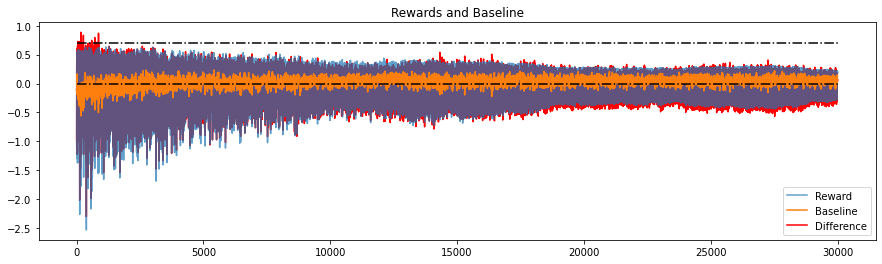

In [185]:
fig = plt.figure(figsize=(15, 4))
plt.plot(agent.reward_history[1:, 0], zorder = -100, label = 'Reward', alpha = 0.7)
plt.plot(agent.reward_history[1:, 1], zorder= -99, label = 'Baseline')
plt.plot(agent.reward_history[1:, 2], 'r', zorder= -101, label = 'Difference' )
plt.hlines(y=np.log(2), xmin=0, xmax=agent.reward_history.shape[0], colors='black', linestyles='dashdot')
plt.hlines(y=0.0, xmin=0, xmax=agent.reward_history.shape[0] , colors='black', linestyles='dashdot')
plt.legend()
plt.title('Rewards and Baseline')

15014


Text(0.5, 1.0, 'Report')

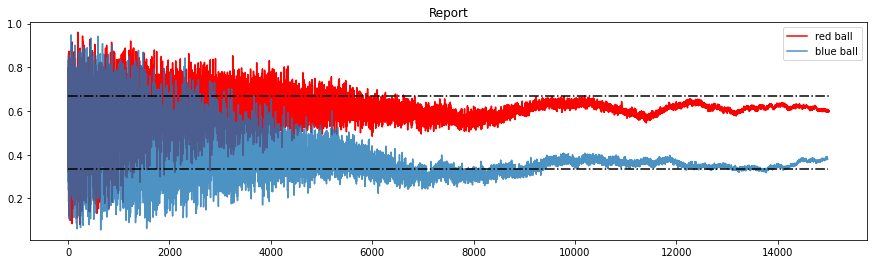

In [186]:
print(len(r_ball_pred_history))
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_pred_history, 'r',zorder=-100, label='red ball')
plt.plot(b_ball_pred_history, zorder=-99, label = 'blue ball', alpha=0.8)
plt.hlines(y=2/3, xmin=0, xmax=len(r_ball_pred_history), colors='black', linestyles='dashdot')
plt.hlines(y=1/3, xmin=0, xmax=len(b_ball_pred_history) , colors='black', linestyles='dashdot')
plt.legend()
plt.title('Report')

In [187]:
print(agent.report([1, 0, 0.5]))

[0.5990247831246831, 0.4009752168753169]


In [188]:
print(agent.report([0, 1, 0.5]))

[0.3782031839445771, 0.6217968160554229]


Text(0.5, 1.0, 'Mean')

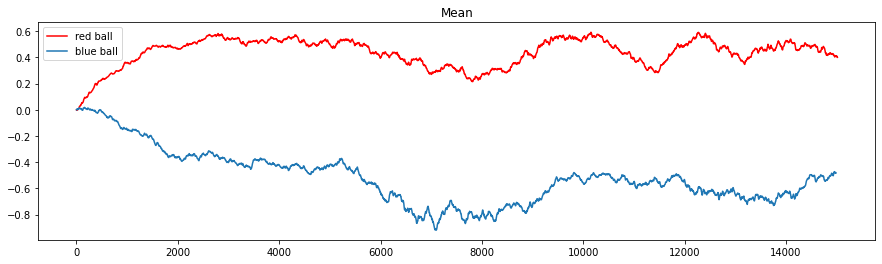

In [189]:
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_mean_history, 'r', label = 'red ball')
plt.plot(b_ball_mean_history,label = 'blue ball')
plt.legend()
plt.title('Mean')

Text(0.5, 1.0, 'Weights for Mean')

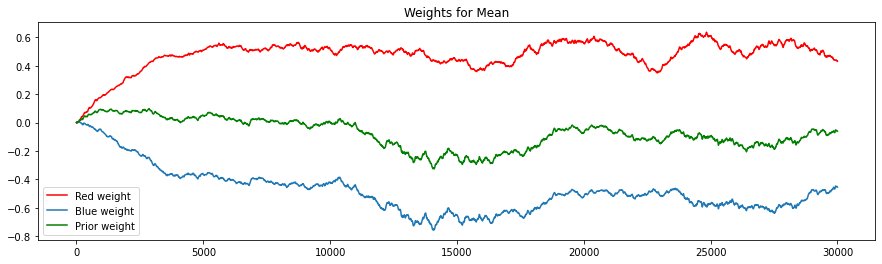

In [190]:
fig = plt.figure(figsize=(15, 4))
plt.plot(mean_weights_history[1:, 0], 'r', label='Red weight')
plt.plot(mean_weights_history[1:, 1], label='Blue weight')
plt.plot(mean_weights_history[1:, 2], 'g', label='Prior weight')
plt.legend()
plt.title('Weights for Mean')

Text(0.5, 1.0, 'Standard Diviation')

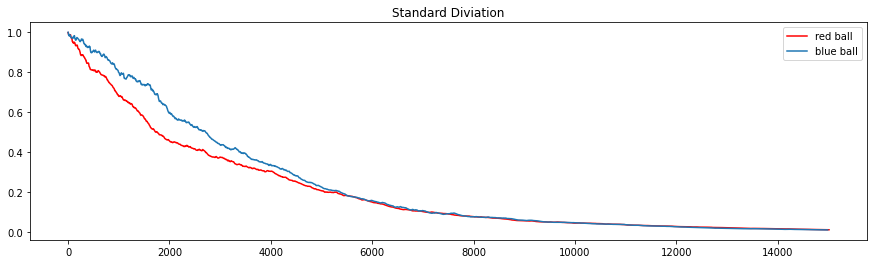

In [191]:
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_std_history, 'r', label = 'red ball')
plt.plot(b_ball_std_history,label = 'blue ball')
plt.legend()
plt.title('Standard Diviation')

Text(0.5, 1.0, 'Weights for standard diviation')

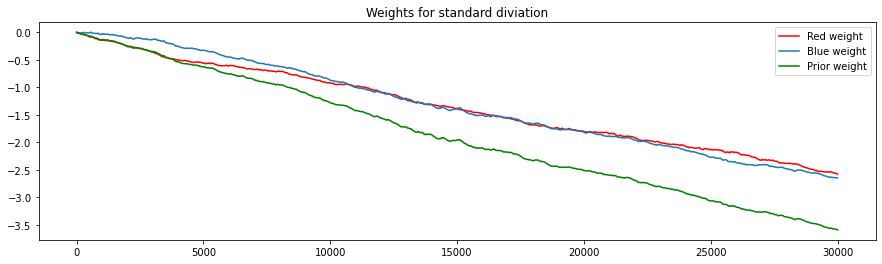

In [192]:
fig = plt.figure(figsize=(15, 4))
plt.plot(std_weights_history[1:, 0], 'r', label='Red weight')
plt.plot(std_weights_history[1:, 1], label='Blue weight')
plt.plot(std_weights_history[1:, 2], 'g', label='Prior weight')
plt.legend()
plt.title('Weights for standard diviation')

Text(0.5, 0.98, 'Signal Mean Gradients')

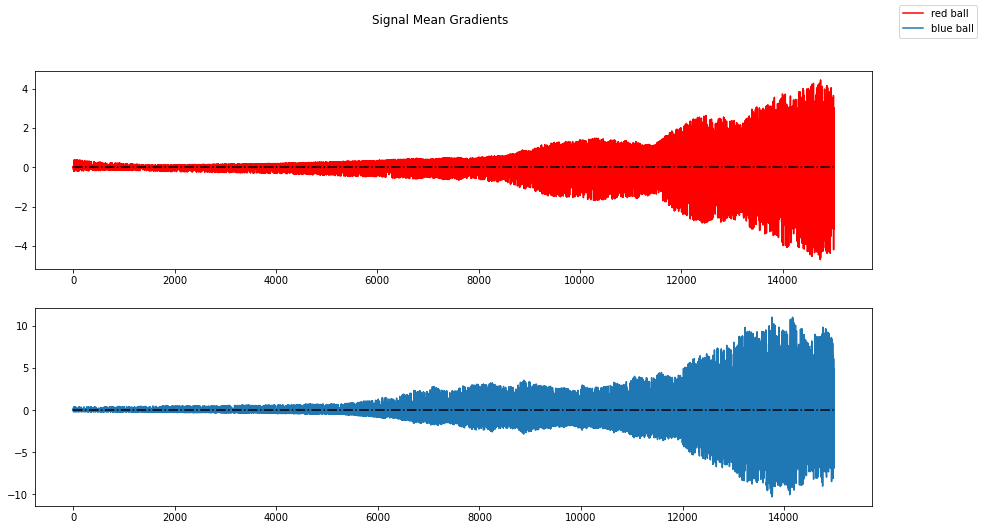

In [193]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_mean_history[1:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_mean_history[1:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients')

Text(0.5, 0.98, 'Signal Mean Gradients (momentum)')

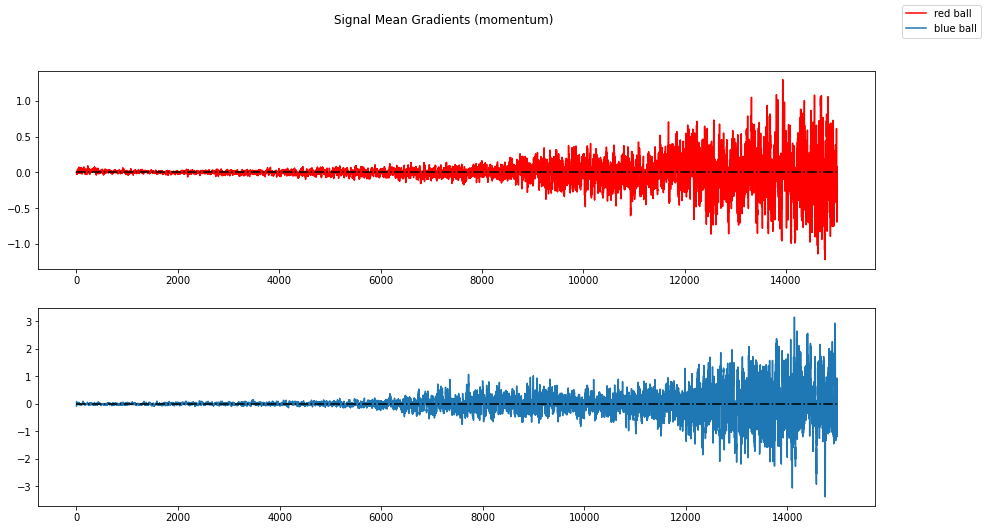

In [194]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_mean_history[1:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_v_mean_history[1:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (momentum)')

Text(0.5, 0.98, 'Signal Mean Gradients (Adam)')

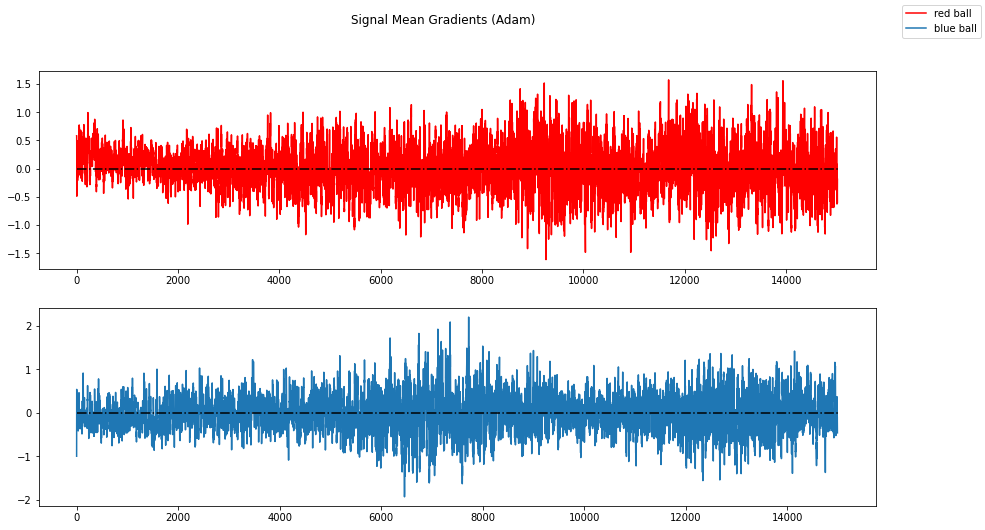

In [195]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_adam_mean_history[1:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_adam_mean_history[1:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (Adam)')

Text(0.5, 0.98, 'Prior Mean Gradient')

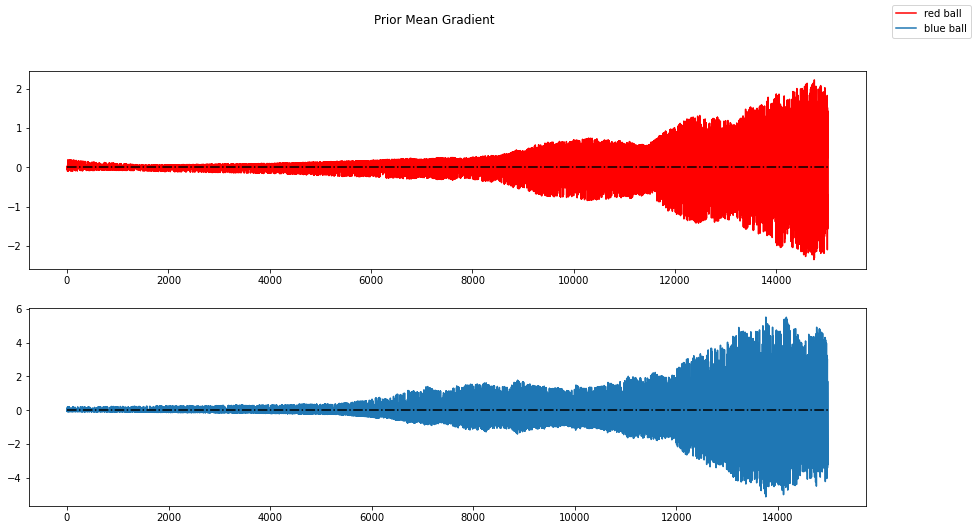

In [196]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_mean_history[1:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_mean_history[1:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Prior Mean Gradient')

Text(0.5, 0.98, 'Prior Mean Gradient (Momentum)')

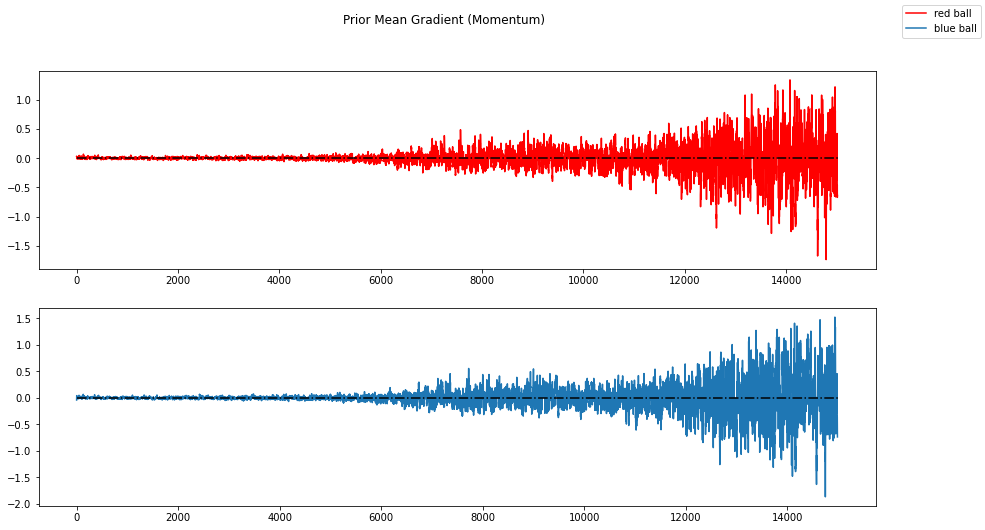

In [197]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_mean_history[1:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_v_mean_history[1:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Prior Mean Gradient (Momentum)')

Text(0.5, 0.98, 'Signal Standard Diviation Gradient')

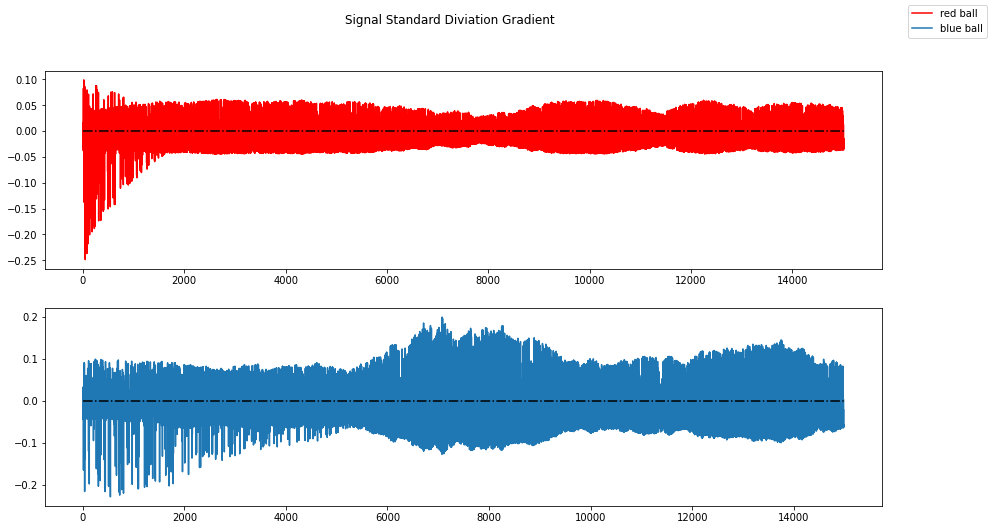

In [198]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_std_history[1:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_std_history[1:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_std_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_std_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Standard Diviation Gradient')

Text(0.5, 0.98, 'Signal Standard Diviation Gradient (Momentum)')

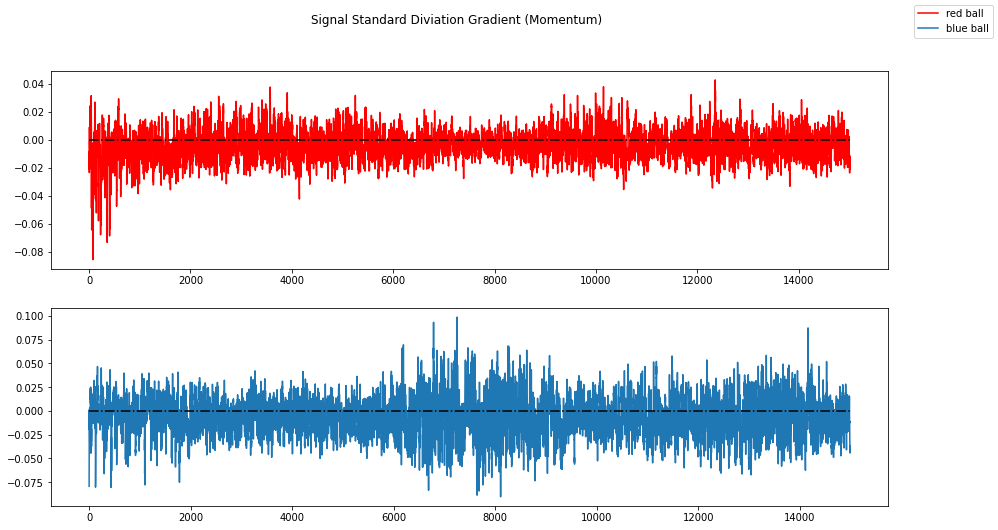

In [199]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_std_history[1:, 0], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_v_std_history[1:, 1],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Standard Diviation Gradient (Momentum)')

Text(0.5, 0.98, 'Signal Standard Diviation Gradient (Adam)')

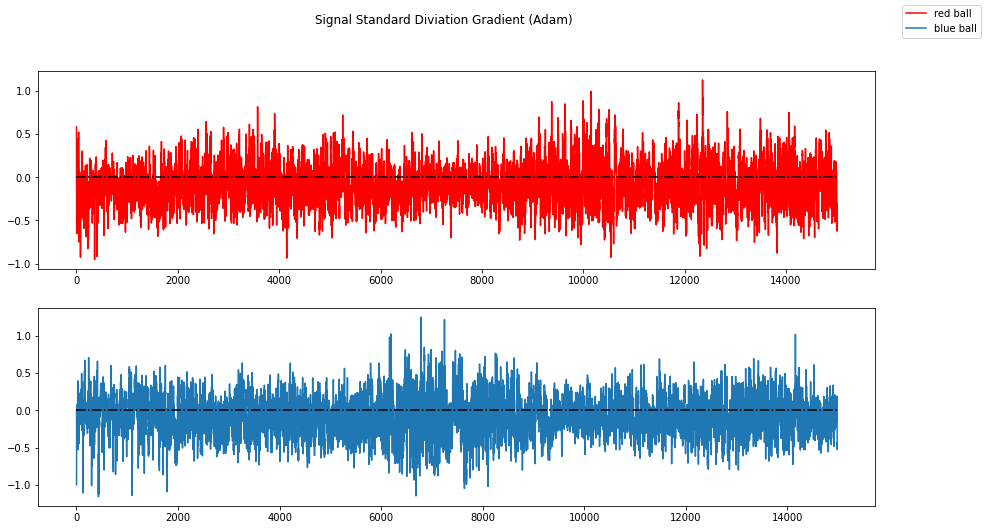

In [200]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_adam_std_history[1:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_adam_std_history[1:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Standard Diviation Gradient (Adam)')